In [13]:
!where python


c:\Users\sasik\AppData\Local\Programs\Python\Python311\python.exe
C:\Users\sasik\AppData\Local\Microsoft\WindowsApps\python.exe


In [14]:
!pip install --upgrade typing-extensions




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


    IMPORT THE REQUIRED FILES

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

Load and Explore the Dataset 

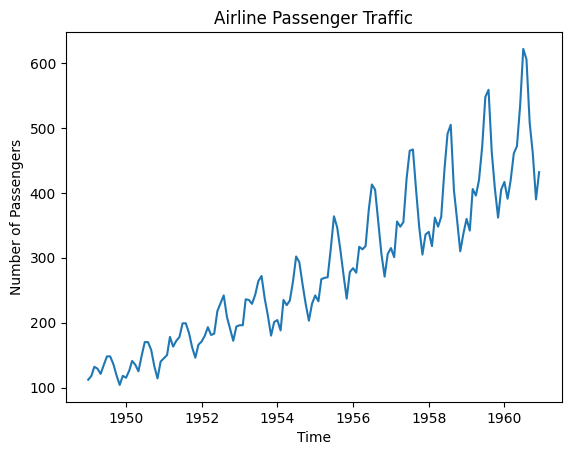

In [3]:
# Load the dataset (URL of the dataset)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Load data
data = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)

# Plot the data
plt.plot(data)
plt.title("Airline Passenger Traffic")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.show()


Check for Stationarity and Preprocess Data

In [17]:
# Function to test stationarity
def test_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary. Differencing required.")

# Test stationarity on original data
test_stationarity(data['Passengers'])

# If not stationary, apply differencing
data_diff = data['Passengers'].diff().dropna()  # First-order differencing
test_stationarity(data_diff)

# If still not stationary, apply second-order differencing
data_diff_2 = data_diff.diff().dropna()  # Second-order differencing
test_stationarity(data_diff_2)

# If still not stationary, apply log transformation to stabilize variance
data_log = np.log(data['Passengers'])
test_stationarity(data_log.dropna())  # Test stationarity of log-transformed data

# If there is seasonality, apply seasonal differencing (for monthly data with yearly seasonality)
# Assuming your data has yearly seasonality (adjust the lag value if needed)
data_seasonal_diff = data['Passengers'] - data['Passengers'].shift(12)  # Apply seasonal differencing (12 for monthly data)
test_stationarity(data_seasonal_diff.dropna())  # Test stationarity after seasonal differencing


ADF Statistic: 0.8153688792060457
p-value: 0.991880243437641
The series is not stationary. Differencing required.
ADF Statistic: -2.8292668241699963
p-value: 0.05421329028382592
The series is not stationary. Differencing required.
ADF Statistic: -16.384231542468502
p-value: 2.7328918500142026e-29
The series is stationary.
ADF Statistic: -1.7170170891069647
p-value: 0.4223667747703892
The series is not stationary. Differencing required.
ADF Statistic: -3.3830207264924814
p-value: 0.011551493085514954
The series is stationary.


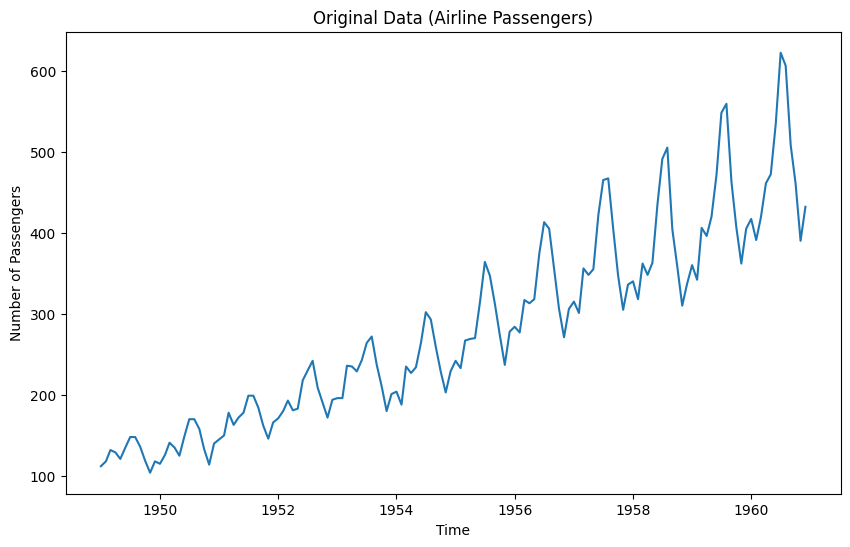

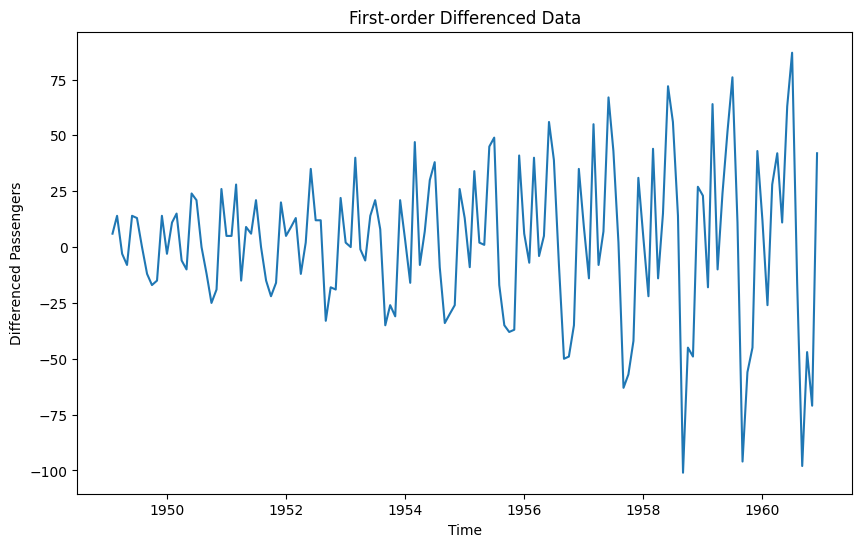

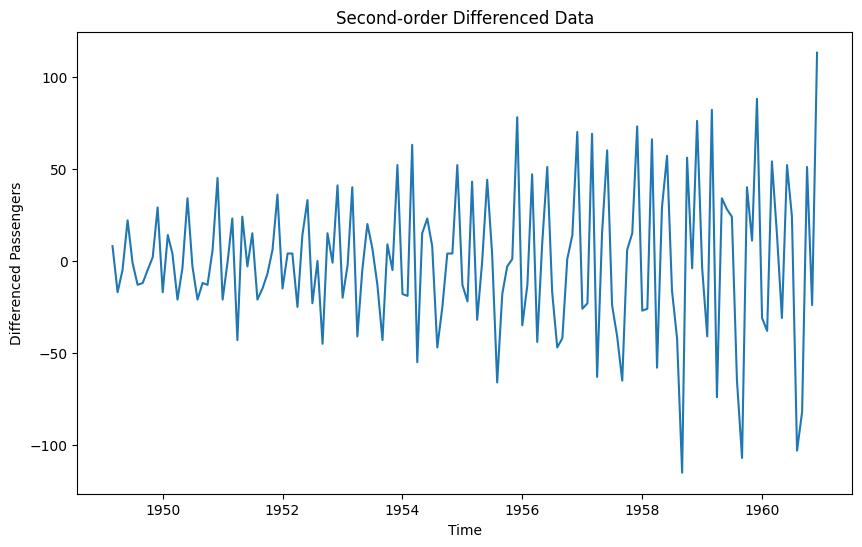

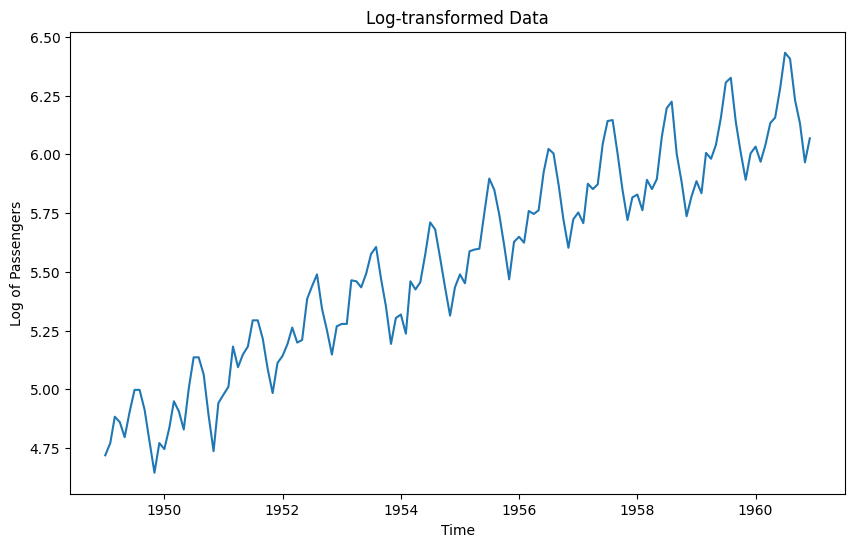

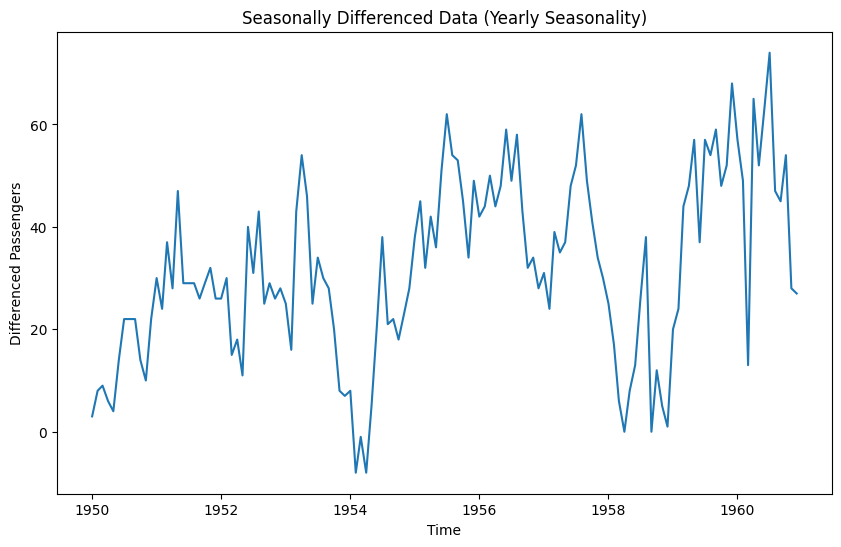

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'])
plt.title("Original Data (Airline Passengers)")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.show()

# Plot first-order differenced data
data_diff = data['Passengers'].diff().dropna()  # First-order differencing
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title("First-order Differenced Data")
plt.xlabel("Time")
plt.ylabel("Differenced Passengers")
plt.show()

# Plot second-order differenced data
data_diff_2 = data_diff.diff().dropna()  # Second-order differencing
plt.figure(figsize=(10, 6))
plt.plot(data_diff_2)
plt.title("Second-order Differenced Data")
plt.xlabel("Time")
plt.ylabel("Differenced Passengers")
plt.show()

# Plot log-transformed data
data_log = np.log(data['Passengers'])
plt.figure(figsize=(10, 6))
plt.plot(data_log)
plt.title("Log-transformed Data")
plt.xlabel("Time")
plt.ylabel("Log of Passengers")
plt.show()

# Plot seasonally differenced data (assuming yearly seasonality, lag=12 for monthly data)
data_seasonal_diff = data['Passengers'] - data['Passengers'].shift(12)  # Apply seasonal differencing (12 for monthly data)
plt.figure(figsize=(10, 6))
plt.plot(data_seasonal_diff.dropna())
plt.title("Seasonally Differenced Data (Yearly Seasonality)")
plt.xlabel("Time")
plt.ylabel("Differenced Passengers")
plt.show()


 ARIMA Model

Split Data into Training and Testing

In [20]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Passengers'][:train_size], data['Passengers'][train_size:]


Fit ARIMA and Make Predictions

c:\Users\sasik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sasik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sasik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model - MAE: 67.3835005991355, RMSE: 80.66394529460587


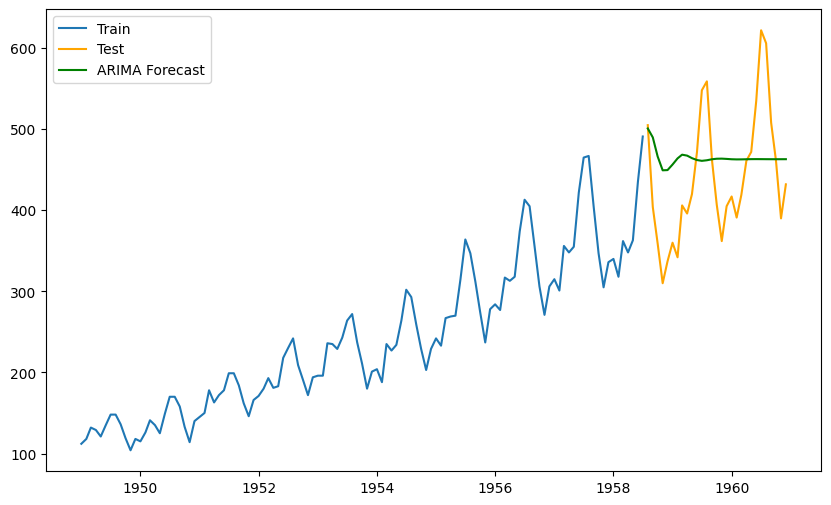

In [21]:
# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()

# Forecast
forecast_arima = arima_result.forecast(steps=len(test))

# Evaluate ARIMA model
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

print(f"ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}")

# Plot ARIMA predictions
plt.figure(figsize=(10, 6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast", color="green")
plt.legend()
plt.show()


 Compare Results

In [22]:
print(f"ARIMA Model - MAE: {mae_arima}, RMSE: {rmse_arima}")



ARIMA Model - MAE: 67.3835005991355, RMSE: 80.66394529460587


In [26]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 67.3835005991355
